In [19]:
## Importing libraries
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import KFold

In [20]:
## Data Cleaning
sample_data = pd.read_csv('../EXAM/data/cleaned_data.csv',encoding='utf-16')
df = pd.DataFrame(sample_data)

# Change constructing year to construction age and squared term for OLS.
df['age'] = 2023 - df['year']
df['age_squared'] = df['age'] ** 2

# Price per squared metre
df['price_per_m2'] = df['price'] / df['living_space']

In [21]:
## Dataset split
# X and y
columns_to_drop = ['price','address','city','type','energy', 'year','area_name', 'price_per_m2']
X,y = df.drop(columns_to_drop,axis=1),df.price
test_size = 0.30 # We have a relatively small dataset
seed = 17082023 

# SPLIT INTO DEVELOPMENT (2/3) AND TEST DATA (1/3)
X_dev, X_test, y_dev, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)

# SPLIT DEVELOPMENT INTO TRAIN (1/3) AND VALIDATION (1/3)
X_train, X_val, y_train, y_val = train_test_split(X_dev, y_dev, test_size=test_size, random_state=seed)

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)

<AxesSubplot: >

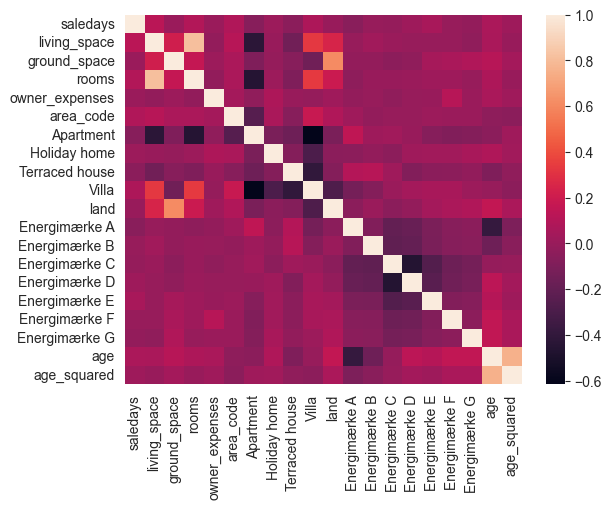

In [22]:
## Heat map
sns.heatmap(X.corr())


In [23]:
## Main model starts
# Linear Regression
pipe_lr = make_pipeline(PolynomialFeatures(), 
                        StandardScaler(),
                        LinearRegression())

pipe_lr.fit(X_dev, y_dev)

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures()),
                ('standardscaler', StandardScaler()),
                ('linearregression', LinearRegression())])

In [24]:
## Lasso
# PREPARATION
perform = [] # Store performance
lambdas = np.logspace(-4, 4, 66) # Grid of lambdas

# FOR EACH LAMBDA, FIT A MODEL ON TRAINING DATA, CHECK PERFORMANCE ON VALIDATION AND STORE MSE
for lambda_ in lambdas:
    pipe_lasso = make_pipeline(PolynomialFeatures(), 
                               StandardScaler(),
                               Lasso(alpha=lambda_, random_state=seed))
    pipe_lasso.fit(X_train, y_train)
    y_pred = pipe_lasso.predict(X_val)
    perform.append(mse(y_pred, y_val))

# CRATE A SERIES WITH PERFORMANCE AND FIND PARM WITH LOWEST MSE    
hyperparam_perform = pd.Series(perform,index=lambdas)
optimal = hyperparam_perform.nsmallest(1)    
# print('Optimal lambda:', optimal.index[0])
# print('Validation MSE: %.3f' % optimal.values[0])

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.299e+15, tolerance: 2.367e+12
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.299e+15, tolerance: 2.367e+12
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

In [25]:
## Lasso 10-fold cross validation
kfolds = KFold(n_splits=10)
folds = list(kfolds.split(X_dev, y_dev))

# Outer loop: lambdas
mseCV = []
for lambda_ in lambdas:

    # Inner loop: folds
    mseCV_ = []
    for train_idx, val_idx in folds:

        # Train model and compute MSE on test fold
        pipe_lassoCV = make_pipeline(PolynomialFeatures(degree=2, include_bias=True),
                                     StandardScaler(),
                                     Lasso(alpha=lambda_, random_state=seed))            
        X_train, y_train = X_dev.iloc[train_idx], y_dev.iloc[train_idx]
        X_val, y_val = X_dev.iloc[val_idx], y_dev.iloc[val_idx]
        pipe_lassoCV.fit(X_train, y_train)        
        mseCV_.append(mse(pipe_lassoCV.predict(X_val), y_val))    

    # Store result    
    mseCV.append(mseCV_) 

# Convert to DataFrame
lambdaCV = pd.DataFrame(mseCV, index=lambdas)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.753e+15, tolerance: 2.956e+12
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.217e+15, tolerance: 2.964e+12
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

In [26]:
## Comparing Lasso CV, Lasso and Linear Reg
# Lasso CV
optimal_lambda = lambdaCV.mean(axis=1).nsmallest(1)
pipe_lassoCV = make_pipeline(PolynomialFeatures(include_bias=False), 
                             StandardScaler(),
                             Lasso(alpha=optimal_lambda.index[0], random_state=seed))
pipe_lassoCV.fit(X_dev,y_dev)

# Lasso
pipe_lasso = make_pipeline(PolynomialFeatures(), 
                           StandardScaler(),
                           Lasso(alpha=optimal.index[0]))
pipe_lasso.fit(X_dev, y_dev) 

# COMPARE MODEL PERFORMANCE ON TEST DATA
models = {'Lasso': pipe_lasso, 'Lasso CV': pipe_lassoCV, 'LinReg': pipe_lr}
for name, model in models.items():
    RMSE = mse(model.predict(X_test), y_test,squared=False)
    R2 = r2_score(model.predict(X_test), y_test)
    print(name, f'RMSE: {round(RMSE, 2)}', f'R2: {round(R2,2)}')

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.279e+14, tolerance: 3.122e+12
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.279e+14, tolerance: 3.122e+12
  model = cd_fast.enet_coordinate_descent(


Lasso RMSE: 738576588646144.8 R2: -0.01
Lasso CV RMSE: 738576588646144.8 R2: -0.01
LinReg RMSE: 340852662664486.5 R2: 0.01
